In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,plot_confusion_matrix, precision_score, recall_score, precision_recall_curve, f1_score

/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


## Define the data path - Customize for your own data

In [2]:
PATH = "/Users/iremn/PythonClass/Spiced/gradient_garlic-code_Work/Week_02/Day_5"
FEATURES = "pumps.csv"
TARGET = "pumps_y.csv"

In [3]:
#Join
FEATURES = os.path.join(PATH, FEATURES)
TARGET = os.path.join(PATH, TARGET)

## Read the Pumps Data

In [4]:
pumps_f = pd.read_csv(FEATURES, index_col = 0)
pumps_y = pd.read_csv(TARGET, index_col = 0)


## Train_Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(pumps_f, pumps_y, test_size = 0.2, random_state=42)

## Data Peek

In [6]:
X_train.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
454,50.0,2013-02-27,Dmdd,2092,DMDD,35.426020,-4.227446,Narmo,0,Internal,...,per bucket,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
510,0.0,2011-03-17,Cmsr,0,Gove,35.510074,-5.724555,Lukali,0,Internal,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
14146,0.0,2011-07-10,Kkkt,0,KKKT,32.499866,-9.081222,Mahakama,0,Lake Rukwa,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other
47410,0.0,2011-04-12,NaN,0,NaN,34.060484,-8.830208,Shule Ya Msingi Chosi A,0,Rufiji,...,monthly,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe
1288,300.0,2011-04-05,Ki,1023,Ki,37.032690,-6.040787,Kwa Mjowe,0,Wami / Ruvu,...,on failure,salty,salty,enough,enough,shallow well,shallow well,groundwater,other,other


In [7]:
X_train.shape

(47520, 39)

In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47520 entries, 454 to 23812
Data columns (total 39 columns):
amount_tsh               47520 non-null float64
date_recorded            47520 non-null object
funder                   44644 non-null object
gps_height               47520 non-null int64
installer                44631 non-null object
longitude                47520 non-null float64
latitude                 47520 non-null float64
wpt_name                 47520 non-null object
num_private              47520 non-null int64
basin                    47520 non-null object
subvillage               47224 non-null object
region                   47520 non-null object
region_code              47520 non-null int64
district_code            47520 non-null int64
lga                      47520 non-null object
ward                     47520 non-null object
population               47520 non-null int64
public_meeting           44831 non-null object
recorded_by              47520 non-null objec

In [9]:
#Check the unique vals within those columns
X_train.nunique()

amount_tsh                  96
date_recorded              351
funder                    1698
gps_height                2401
installer                 1923
longitude                46043
latitude                 46044
wpt_name                 30742
num_private                 59
basin                        9
subvillage               17232
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2076
population                 971
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2541
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity

* Seems like there are some redundant columns such as "quantity" and "quantity_group" and so on. One can drop those columns
* Split the categorical and numerical features
* Do EDA, wrangle data but don't forget to do all with test data too

In [10]:
pumps_num = X_train.select_dtypes(exclude ='object') 
pumps_cat = X_train.select_dtypes(include = 'object')

In [11]:
pumps_num.head()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
id,,,,,,,,,
454,50.0,2092,35.426020,-4.227446,0,21,1,160,1998
510,0.0,0,35.510074,-5.724555,0,1,6,0,0
14146,0.0,0,32.499866,-9.081222,0,12,6,0,0
47410,0.0,0,34.060484,-8.830208,0,12,7,0,0
1288,300.0,1023,37.032690,-6.040787,0,5,1,120,1997


In [12]:
pumps_cat.head()

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
454,2013-02-27,Dmdd,DMDD,Narmo,Internal,Bashnet Kati,Manyara,Babati,Bashinet,True,...,per bucket,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
510,2011-03-17,Cmsr,Gove,Lukali,Internal,Lukali,Dodoma,Bahi,Lamaiti,True,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
14146,2011-07-10,Kkkt,KKKT,Mahakama,Lake Rukwa,Chawalikozi,Mbeya,Mbozi,Ndalambo,True,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other
47410,2011-04-12,NaN,NaN,Shule Ya Msingi Chosi A,Rufiji,Shuleni,Mbeya,Mbarali,Chimala,True,...,monthly,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe
1288,2011-04-05,Ki,Ki,Kwa Mjowe,Wami / Ruvu,Ngholong,Morogoro,Kilosa,Chakwale,True,...,on failure,salty,salty,enough,enough,shallow well,shallow well,groundwater,other,other


In [13]:
pumps_num['date_recorded'] = pumps_cat['date_recorded']
pumps_cat = pumps_cat.drop('date_recorded', axis = 1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Work on the categorical columns

In [14]:
pumps_cat.head()

,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
454,Dmdd,DMDD,Narmo,Internal,Bashnet Kati,Manyara,Babati,Bashinet,True,GeoData Consultants Ltd,...,per bucket,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
510,Cmsr,Gove,Lukali,Internal,Lukali,Dodoma,Bahi,Lamaiti,True,GeoData Consultants Ltd,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
14146,Kkkt,KKKT,Mahakama,Lake Rukwa,Chawalikozi,Mbeya,Mbozi,Ndalambo,True,GeoData Consultants Ltd,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other
47410,NaN,NaN,Shule Ya Msingi Chosi A,Rufiji,Shuleni,Mbeya,Mbarali,Chimala,True,GeoData Consultants Ltd,...,monthly,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe
1288,Ki,Ki,Kwa Mjowe,Wami / Ruvu,Ngholong,Morogoro,Kilosa,Chakwale,True,GeoData Consultants Ltd,...,on failure,salty,salty,enough,enough,shallow well,shallow well,groundwater,other,other


In [15]:
pumps_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47520 entries, 454 to 23812
Data columns (total 29 columns):
funder                   44644 non-null object
installer                44631 non-null object
wpt_name                 47520 non-null object
basin                    47520 non-null object
subvillage               47224 non-null object
region                   47520 non-null object
lga                      47520 non-null object
ward                     47520 non-null object
public_meeting           44831 non-null object
recorded_by              47520 non-null object
scheme_management        44418 non-null object
scheme_name              24997 non-null object
permit                   45081 non-null object
extraction_type          47520 non-null object
extraction_type_group    47520 non-null object
extraction_type_class    47520 non-null object
management               47520 non-null object
management_group         47520 non-null object
payment                  47520 non-null obj

In [16]:
pumps_cat.nunique()

funder                    1698
installer                 1923
wpt_name                 30742
basin                        9
subvillage               17232
region                      21
lga                        125
ward                      2076
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2541
permit                       2
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity                     5
quantity_group               5
source                      10
source_type                  7
source_class                 3
waterpoint_type              7
waterpoint_type_group        6
dtype: int64

Looks like "recorded by" has a single value - drop it

In [17]:
pumps_cat = pumps_cat.drop('recorded_by', axis=1)

### Fill cat NaNs with "not available"

In [18]:
pumps_cat = pumps_cat.fillna('not available')

In [19]:
pumps_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47520 entries, 454 to 23812
Data columns (total 28 columns):
funder                   47520 non-null object
installer                47520 non-null object
wpt_name                 47520 non-null object
basin                    47520 non-null object
subvillage               47520 non-null object
region                   47520 non-null object
lga                      47520 non-null object
ward                     47520 non-null object
public_meeting           47520 non-null object
scheme_management        47520 non-null object
scheme_name              47520 non-null object
permit                   47520 non-null object
extraction_type          47520 non-null object
extraction_type_group    47520 non-null object
extraction_type_class    47520 non-null object
management               47520 non-null object
management_group         47520 non-null object
payment                  47520 non-null object
payment_type             47520 non-null obj

In [20]:
pumps_cat.nunique()

funder                    1699
installer                 1924
wpt_name                 30742
basin                        9
subvillage               17233
region                      21
lga                        125
ward                      2076
public_meeting               3
scheme_management           13
scheme_name               2542
permit                       3
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity                     5
quantity_group               5
source                      10
source_type                  7
source_class                 3
waterpoint_type              7
waterpoint_type_group        6
dtype: int64

### Remove Unnecessary Redundant Cols

In [21]:
#Remove some categorical vars
garbage_cat = ['extraction_type_group','extraction_type_class',
               'waterpoint_type_group','source_type',
              'payment_type','quality_group','quantity_group']

In [22]:
pumps_cat = pumps_cat.drop(columns=garbage_cat)

In [23]:
pumps_cat.columns

Index(['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region',
       'lga', 'ward', 'public_meeting', 'scheme_management', 'scheme_name',
       'permit', 'extraction_type', 'management', 'management_group',
       'payment', 'water_quality', 'quantity', 'source', 'source_class',
       'waterpoint_type'],
      dtype='object')

## Handle Numerical data

In [24]:
pumps_num.head()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,date_recorded
id,,,,,,,,,,
454,50.0,2092,35.426020,-4.227446,0,21,1,160,1998,2013-02-27
510,0.0,0,35.510074,-5.724555,0,1,6,0,0,2011-03-17
14146,0.0,0,32.499866,-9.081222,0,12,6,0,0,2011-07-10
47410,0.0,0,34.060484,-8.830208,0,12,7,0,0,2011-04-12
1288,300.0,1023,37.032690,-6.040787,0,5,1,120,1997,2011-04-05


In [25]:
pumps_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47520 entries, 454 to 23812
Data columns (total 10 columns):
amount_tsh           47520 non-null float64
gps_height           47520 non-null int64
longitude            47520 non-null float64
latitude             47520 non-null float64
num_private          47520 non-null int64
region_code          47520 non-null int64
district_code        47520 non-null int64
population           47520 non-null int64
construction_year    47520 non-null int64
date_recorded        47520 non-null object
dtypes: float64(3), int64(6), object(1)
memory usage: 4.0+ MB


In [26]:
#Convert date recorded to datetime
pumps_num['recorded'] = pd.to_datetime(pumps_num['date_recorded'])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [27]:
pumps_num['recorded_year'] = pumps_num['recorded'].dt.year

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [28]:
pumps_num.head()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,date_recorded,recorded,recorded_year
id,,,,,,,,,,,,
454,50.0,2092,35.426020,-4.227446,0,21,1,160,1998,2013-02-27,2013-02-27,2013
510,0.0,0,35.510074,-5.724555,0,1,6,0,0,2011-03-17,2011-03-17,2011
14146,0.0,0,32.499866,-9.081222,0,12,6,0,0,2011-07-10,2011-07-10,2011
47410,0.0,0,34.060484,-8.830208,0,12,7,0,0,2011-04-12,2011-04-12,2011
1288,300.0,1023,37.032690,-6.040787,0,5,1,120,1997,2011-04-05,2011-04-05,2011


In [29]:
#Impute mean construction_year
mean_imputer = SimpleImputer(missing_values=0, strategy='mean')
pumps_num['construction_year_imp'] = mean_imputer.fit_transform(pumps_num['construction_year'].values.reshape(-1,1))
pumps_num['construction_year_imp'] = pumps_num['construction_year_imp'].astype('int')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [30]:
pumps_num['age'] = pumps_num['recorded_year'] - pumps_num['construction_year_imp']

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [31]:
pumps_num.head()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,date_recorded,recorded,recorded_year,construction_year_imp,age
id,,,,,,,,,,,,,,
454,50.0,2092,35.426020,-4.227446,0,21,1,160,1998,2013-02-27,2013-02-27,2013,1998,15
510,0.0,0,35.510074,-5.724555,0,1,6,0,0,2011-03-17,2011-03-17,2011,1996,15
14146,0.0,0,32.499866,-9.081222,0,12,6,0,0,2011-07-10,2011-07-10,2011,1996,15
47410,0.0,0,34.060484,-8.830208,0,12,7,0,0,2011-04-12,2011-04-12,2011,1996,15
1288,300.0,1023,37.032690,-6.040787,0,5,1,120,1997,2011-04-05,2011-04-05,2011,1997,14


There are some categorical variables leaked in here:
- region_code
- district_code

In [32]:
pumps_cat[['region_code', 'district_code']] = pumps_num[['region_code', 'district_code']]

In [33]:
pumps_num = pumps_num.drop(['region_code', 'district_code'], axis = 1)

In [34]:
pumps_num.head()

,amount_tsh,gps_height,longitude,latitude,num_private,population,construction_year,date_recorded,recorded,recorded_year,construction_year_imp,age
id,,,,,,,,,,,,
454,50.0,2092,35.426020,-4.227446,0,160,1998,2013-02-27,2013-02-27,2013,1998,15
510,0.0,0,35.510074,-5.724555,0,0,0,2011-03-17,2011-03-17,2011,1996,15
14146,0.0,0,32.499866,-9.081222,0,0,0,2011-07-10,2011-07-10,2011,1996,15
47410,0.0,0,34.060484,-8.830208,0,0,0,2011-04-12,2011-04-12,2011,1996,15
1288,300.0,1023,37.032690,-6.040787,0,120,1997,2011-04-05,2011-04-05,2011,1997,14


In [35]:
pumps_num_copy = pumps_num[['amount_tsh', 'age', 'construction_year_imp', 'population', 'gps_height']]

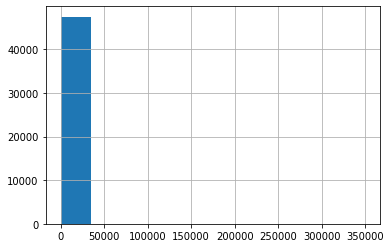

In [36]:
pumps_num_copy['amount_tsh'].hist()

In [37]:
pumps_num_copy['amount_tsh'].unique()

array([5.00e+01, 0.00e+00, 3.00e+02, 1.00e+01, 8.00e+03, 2.50e+02,
       5.00e+02, 3.00e+01, 1.00e+03, 6.00e+03, 1.00e+02, 4.70e+03,
       4.00e+01, 1.50e+03, 2.40e+03, 2.00e+03, 1.50e+01, 1.00e+04,
       5.00e+00, 2.00e+01, 3.00e+03, 2.00e+02, 6.00e+02, 2.50e+03,
       5.00e+03, 2.50e+01, 4.00e+02, 8.50e+03, 4.50e+02, 6.00e+00,
       1.20e+03, 4.00e+03, 7.50e+02, 7.00e+02, 7.00e+00, 1.63e+04,
       3.60e+03, 1.20e+04, 2.50e+04, 1.50e+04, 1.50e+02, 2.20e+03,
       7.20e+03, 2.00e+00, 2.00e+04, 2.80e+03, 7.00e+01, 1.20e+01,
       3.50e+03, 4.00e+04, 3.30e+01, 3.50e+01, 7.00e+03, 1.17e+05,
       7.50e+03, 6.00e+01, 1.30e+03, 7.00e+04, 5.00e+04, 6.50e+03,
       2.00e+05, 1.10e+04, 3.00e+04, 4.50e+03, 6.30e+03, 1.40e+04,
       3.50e+05, 3.50e+02, 9.00e+00, 4.50e+04, 2.60e+04, 1.60e+04,
       2.00e-01, 5.20e+02, 8.00e+02, 6.00e+04, 9.00e+03, 5.50e+02,
       5.50e+03, 2.20e+02, 3.06e+02, 2.60e+01, 1.70e+05, 1.30e+04,
       5.90e+02, 1.00e+00, 1.20e+05, 5.30e+01, 1.80e+04, 5.40e

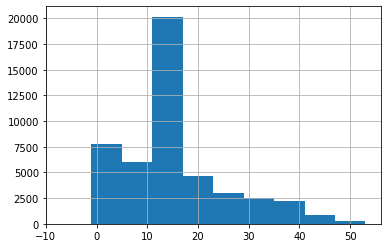

In [38]:
pumps_num_copy['age'].hist()

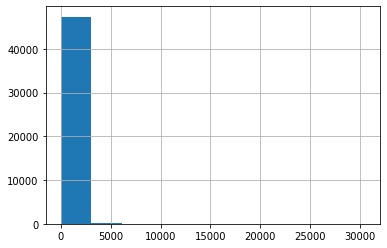

In [39]:
pumps_num_copy['population'].hist()

In [40]:
scaler = RobustScaler()
nums_scaled = scaler.fit_transform(pumps_num_copy)

In [41]:
nums_scaled = pd.DataFrame(nums_scaled, columns=pumps_num_copy.columns)

### Back to categoricals

In [42]:
pumps_cat.head()

,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,scheme_management,...,management,management_group,payment,water_quality,quantity,source,source_class,waterpoint_type,region_code,district_code
id,,,,,,,,,,,,,,,,,,,,,
454,Dmdd,DMDD,Narmo,Internal,Bashnet Kati,Manyara,Babati,Bashinet,True,Water Board,...,water board,user-group,pay per bucket,soft,insufficient,spring,groundwater,communal standpipe,21,1
510,Cmsr,Gove,Lukali,Internal,Lukali,Dodoma,Bahi,Lamaiti,True,VWC,...,vwc,user-group,never pay,soft,enough,shallow well,groundwater,hand pump,1,6
14146,Kkkt,KKKT,Mahakama,Lake Rukwa,Chawalikozi,Mbeya,Mbozi,Ndalambo,True,VWC,...,vwc,user-group,never pay,soft,enough,shallow well,groundwater,other,12,6
47410,not available,not available,Shule Ya Msingi Chosi A,Rufiji,Shuleni,Mbeya,Mbarali,Chimala,True,VWC,...,vwc,user-group,pay monthly,soft,insufficient,river,surface,communal standpipe,12,7
1288,Ki,Ki,Kwa Mjowe,Wami / Ruvu,Ngholong,Morogoro,Kilosa,Chakwale,True,VWC,...,vwc,user-group,pay when scheme fails,salty,enough,shallow well,groundwater,other,5,1


In [43]:
pumps_cat[['region_code', 'district_code']] = pumps_cat[['region_code', 'district_code']].astype('str')

In [44]:
pumps_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47520 entries, 454 to 23812
Data columns (total 23 columns):
funder               47520 non-null object
installer            47520 non-null object
wpt_name             47520 non-null object
basin                47520 non-null object
subvillage           47520 non-null object
region               47520 non-null object
lga                  47520 non-null object
ward                 47520 non-null object
public_meeting       47520 non-null object
scheme_management    47520 non-null object
scheme_name          47520 non-null object
permit               47520 non-null object
extraction_type      47520 non-null object
management           47520 non-null object
management_group     47520 non-null object
payment              47520 non-null object
water_quality        47520 non-null object
quantity             47520 non-null object
source               47520 non-null object
source_class         47520 non-null object
waterpoint_type      47520 no

In [45]:
pumps_cat.nunique()

funder                1699
installer             1924
wpt_name             30742
basin                    9
subvillage           17233
region                  21
lga                    125
ward                  2076
public_meeting           3
scheme_management       13
scheme_name           2542
permit                   3
extraction_type         18
management              12
management_group         5
payment                  7
water_quality            8
quantity                 5
source                  10
source_class             3
waterpoint_type          7
region_code             27
district_code           20
dtype: int64

In [46]:
cat_copy = pumps_cat[['extraction_type', 'payment', 'quantity', 'waterpoint_type', 'source_class']]

In [47]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
cats_ohe = ohe.fit_transform(cat_copy)

In [48]:
cats_ohe.shape

(47520, 40)

In [49]:
#Get column names
column_names_cat = []
for col in ohe.categories_:
    for sub_cat in col:
        column_names_cat.append(sub_cat)
    

In [50]:
len(column_names_cat)

40

In [51]:
cats_ohe_df = pd.DataFrame(cats_ohe, columns = column_names_cat)

In [52]:
cats_ohe_df.head()

,afridev,cemo,climax,gravity,india mark ii,india mark iii,ksb,mono,nira/tanira,other,...,cattle trough,communal standpipe,communal standpipe multiple,dam,hand pump,improved spring,other,groundwater,surface,unknown
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


### Final DF

In [82]:
pumps_final = pd.concat([cats_ohe_df, nums_scaled], axis = 1)

In [83]:
pumps_final.head()

,afridev,cemo,climax,gravity,india mark ii,india mark iii,ksb,mono,nira/tanira,other,...,improved spring,other,groundwater,surface,unknown,amount_tsh,age,construction_year_imp,population,gps_height
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2.5,0.000000,0.250,0.633803,1.304545
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.000,-0.117371,-0.280303
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.000000,0.000,-0.117371,-0.280303
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000,-0.117371,-0.280303
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,15.0,-0.111111,0.125,0.446009,0.494697


In [84]:
#Check if the target variables are balanced - ADDRESS this in the end but DO NOT Apply to TEST
y_train['status_group'].value_counts()

functional                 25802
non functional             18252
functional needs repair     3466
Name: status_group, dtype: int64

## LogReg

In [85]:
logreg = LogisticRegression(random_state=42, max_iter=500, class_weight='balanced', solver = 'liblinear', multi_class='ovr')

In [86]:
logreg.fit(pumps_final, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=500, multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [87]:
y_pred = logreg.predict(pumps_final)

In [88]:
y_proba_pred = logreg.predict_proba(pumps_final)

In [89]:
accuracy_score(y_train, y_pred)

0.7028409090909091

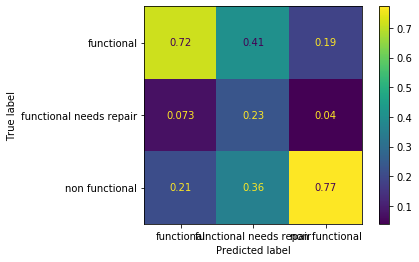

In [90]:
plot_confusion_matrix(logreg,pumps_final, y_train, normalize='pred')

In [91]:
precision_score(y_train, y_pred, average='weighted')

0.7023872453491035

In [92]:
recall_score(y_train, y_pred, average='weighted')

0.7028409090909091

In [93]:
f1_score(y_train, y_pred, average='weighted')

0.6943763181410805

### Random Forest

In [94]:
rf = RandomForestClassifier(class_weight='balanced')

# Parameter Grid 

param_grid = {
    'max_depth': [1, 5, 8, 32],#, 8, 32, 128, None],
    'n_estimators': [10, 100, 1000]#, 100, 1000, 1000]
}

In [95]:
cv = GridSearchCV(rf, param_grid, 
                  cv=5, n_jobs=4)

cv.fit(pumps_final, y_train)
print('Performing Random Forest...')

res = pd.DataFrame(cv.cv_results_)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Performing Random Forest...


In [96]:
params = res.sort_values(by='rank_test_score').iloc[0]['params']

In [97]:
rf_cv = RandomForestClassifier(max_depth = params['max_depth'], n_estimators=params['n_estimators'], class_weight='balanced')

In [98]:
rf_cv.fit(pumps_final, y_train)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=32, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [99]:
y_pred_rf = rf_cv.predict(pumps_final)

In [100]:
y_pred_rf_proba = rf_cv.predict_proba(pumps_final)

In [101]:
accuracy_score(y_train, y_pred_rf)

0.8763888888888889

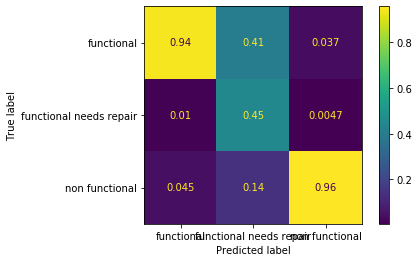

In [102]:
plot_confusion_matrix(rf_cv,pumps_final, y_train, normalize='pred')

In [103]:
precision_score(y_train, y_pred_rf, average='weighted')

0.9134991971016673

In [104]:
recall_score(y_train, y_pred_rf, average='weighted')

0.8763888888888889

In [105]:
print('Precision is: ', precision_score(y_train, y_pred_rf, average='weighted'))
print('Recall is: ', recall_score(y_train, y_pred_rf, average='weighted'))
print('f1 score is: ', f1_score(y_train, y_pred_rf, average='weighted'))


Precision is:  0.9134991971016673
Recall is:  0.8763888888888889
f1 score is:  0.8878588395704085


## XGboost 

In [124]:
xgb = XGBClassifier(max_depth = 32, random_state = 42  )


In [121]:
cols=pd.Series(pumps_final.columns)

for dup in cols[cols.duplicated()].unique(): 
    cols[cols[cols == dup].index.values.tolist()] = [dup + '.' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]

# rename the columns with the cols list.
pumps_final.columns=cols


In [122]:
pumps_final.columns

Index(['afridev', 'cemo', 'climax', 'gravity', 'india mark ii',
       'india mark iii', 'ksb', 'mono', 'nira/tanira', 'other_0',
       'other - mkulima/shinyanga', 'other - play pump', 'other - rope pump',
       'other - swn 81', 'submersible', 'swn 80', 'walimi', 'windmill',
       'never pay', 'other', 'pay annually', 'pay monthly', 'pay per bucket',
       'pay when scheme fails', 'unknown', 'dry', 'enough', 'insufficient',
       'seasonal', 'unknown.1', 'cattle trough', 'communal standpipe',
       'communal standpipe multiple', 'dam', 'hand pump', 'improved spring',
       'other.1', 'groundwater', 'surface', 'unknown.2', 'amount_tsh', 'age',
       'construction_year_imp', 'population', 'gps_height'],
      dtype='object')

In [125]:
xgb.fit(pumps_final, y_train)
print("accuracy on training set: %f" % xgb.score(pumps_final, y_train, sample_weight=))


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy on training set: 0.916330


In [126]:
y_pred_xgb = xgb.predict(pumps_final)

In [127]:
print('Precision is: ', precision_score(y_train, y_pred_xgb, average='weighted'))
print('Recall is: ', recall_score(y_train, y_pred_xgb, average='weighted'))
print('f1 score is: ', f1_score(y_train, y_pred_xgb, average='weighted'))


Precision is:  0.9182611161186517
Recall is:  0.9163299663299663
f1 score is:  0.9146577220846488


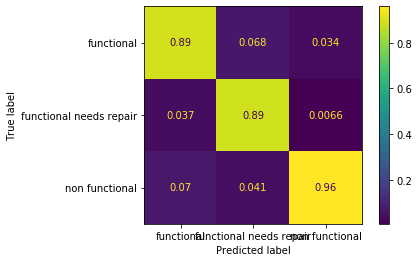

In [128]:
plot_confusion_matrix(xgb,pumps_final, y_train, normalize='pred')